In [1]:
import pandas as pd
import os
import jsonlines
import importlib
import sys
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])
stopwords = set(stopwords.words("english"))

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /home/peichi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/peichi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
FIG_PATH = "results/"

## Indexing

In [3]:
# importlib.reload(sys.modules['indexing'])
from indexing import Indexer, IndexType, BasicInvertedIndex
from document_preprocessor import RegexTokenizer

/home/peichi/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
dataset_file_path = "data/postings_dataset.jsonl"

In [5]:
print('initializing tokenizer...')
preprocessor = RegexTokenizer('\w+')

print('reading stopwords...')
stopwords = stopwords
# with open('data/stopwords.txt', 'r') as file:
#     for stopword in file:
#         stopwords.add(stopword[:-1])

print('indexing document...')
title_index_directory_name = 'data/index-title'
if os.path.exists(title_index_directory_name):
    print('- reading title index from file...')
    title_index = BasicInvertedIndex()
    title_index.load(title_index_directory_name)
else:
    print('- creating title index...')
    title_index = Indexer.create_index(
        IndexType.BasicInvertedIndex, dataset_file_path, preprocessor, stopwords, 0, text_key='title')
print("number of documents", title_index.statistics['number_of_documents'])
main_index_directory_name = 'data/index-description'
if os.path.exists(main_index_directory_name):
    print('- reading document index from file...')
    main_index = BasicInvertedIndex()
    main_index.load(main_index_directory_name)
else:
    print('- creating document index...')
    main_index = Indexer.create_index(
        IndexType.BasicInvertedIndex, dataset_file_path, preprocessor, stopwords, 0, text_key="description")
print("number of documents", main_index.statistics['number_of_documents'])

initializing tokenizer...
reading stopwords...
indexing document...
- reading title index from file...
number of documents 123842
- reading document index from file...
number of documents 123842


## Loading Dataset

In [6]:
import pandas as pd
resume_data = pd.read_csv("data/resume_data.csv")

In [7]:
# resume_data.head()

In [8]:
testing_resume_data = resume_data.sample(frac=0.05, random_state=123)
len(testing_resume_data)

124

In [9]:
testing_resume_data.to_csv("data/testing.csv")

In [10]:
# business_field = ["BPO","HR","PUBLIC-RELATIONS","CONSULTANT","BANKING","SALES","ACCOUNTANT","FINANCE","BUSINESS-DEVELOPMENT",]
# technology_field = ["AUTOMOBILE","AVIATION","ENGINEERING","INFORMATION-TECHNOLOGY"]
# # SECONDARY INTEREST : ARTS, HUMANITIES FASHION
# secondary_interest = ["AGRICULTURE","DIGITAL-MEDIA","APPAREL","TEACHER","ARTS","DESIGNER","CONSTRUCTION","HEALTHCARE","FITNESS","CHEF","ADVOCATE"]

In [11]:
# job_category = {}
# for cat in business_field:
#     job_category[cat] = 'BUSSINESS'
# for cat in technology_field:
#     job_category[cat] = 'TECHNOLOGY'
# for cat in secondary_interest:
#     job_category[cat] = 'OTHERS'
# job_category

In [12]:
# import json
# with open("data/job_categories.json", "w") as f:
#     f.write(json.dumps(job_category, indent=4))

# Ranking

In [13]:
# importlib.reload(sys.modules['relevance'])
from relevance import run_relevance_tests
postings_category_filename = "data/predicted_postings.csv.gz"
resume_category_filename = "data/testing.csv"
job_category_filename = "data/job_categories.json"

In [14]:
# resume_category = pd.read_csv(resume_category_filename)
# resume_category

In [83]:
testing_resume_data = pd.read_csv(resume_category_filename)
testing_cat_cnt = testing_resume_data["Category"].value_counts()
testing_cat_cnt

Category
CONSULTANT                11
ARTS                       9
BANKING                    9
PUBLIC-RELATIONS           8
HEALTHCARE                 8
ADVOCATE                   7
CHEF                       6
BUSINESS-DEVELOPMENT       6
DIGITAL-MEDIA              6
TEACHER                    5
INFORMATION-TECHNOLOGY     5
FITNESS                    5
SALES                      5
FINANCE                    4
HR                         4
ENGINEERING                4
AVIATION                   3
AGRICULTURE                3
DESIGNER                   3
CONSTRUCTION               3
ACCOUNTANT                 3
APPAREL                    3
BPO                        2
AUTOMOBILE                 2
Name: count, dtype: int64

In [31]:
len(testing_cat_cnt)

24

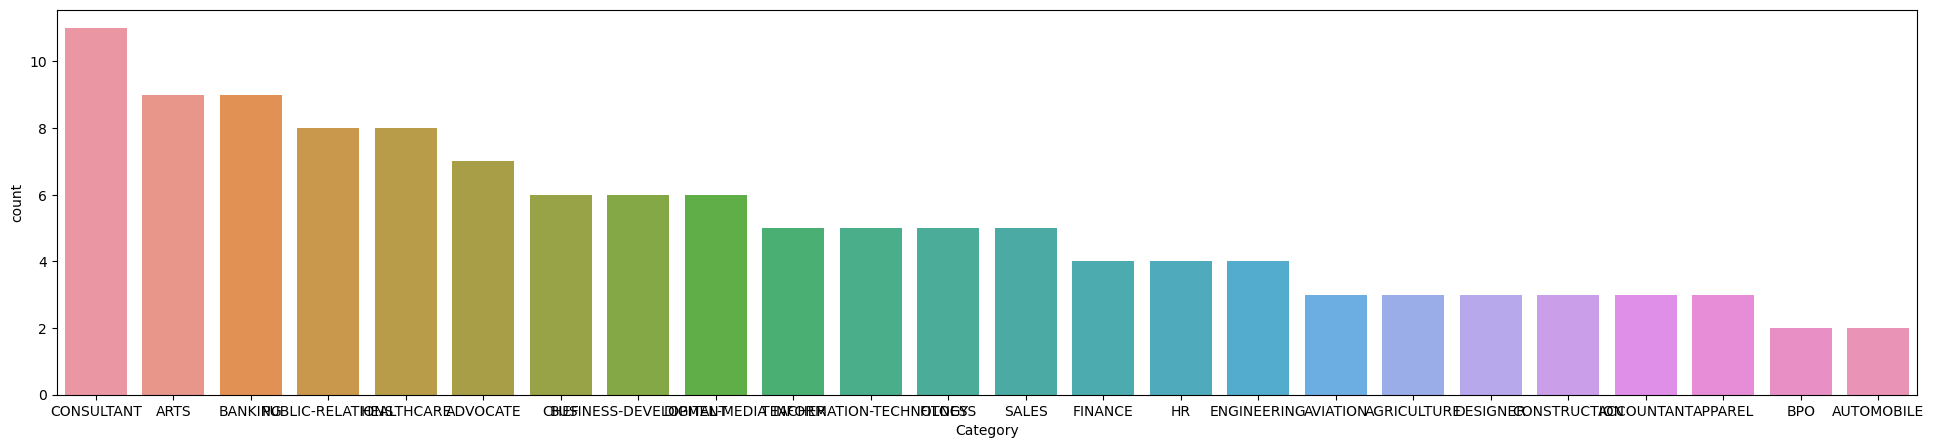

In [84]:
plt.figure(figsize=(24,5))
testing_cat_cnt = pd.DataFrame(testing_cat_cnt).reset_index().rename(columns={"index": "value", 0: "count"})
sns.barplot(x='Category', y='count', data=testing_cat_cnt)
plt.save(FIG_PATH + "testing_categories.csv")

In [90]:
postings_data = pd.read_csv(postings_category_filename)

In [96]:
postings_cat = postings_data["predicted"].value_counts(dropna=False)

In [99]:
postings_cat

predicted
INFORMATION-TECHNOLOGY    23451
HEALTHCARE                21867
SALES                     16224
BUSINESS-DEVELOPMENT      14769
HR                        11424
ENGINEERING                8763
ACCOUNTANT                 4223
FINANCE                    3667
ADVOCATE                   2421
CONSULTANT                 2388
TEACHER                    2279
CHEF                       1829
DESIGNER                   1824
CONSTRUCTION               1677
BANKING                    1669
AUTOMOBILE                 1627
FITNESS                    1206
BPO                         915
AVIATION                    879
PUBLIC-RELATIONS            740
Name: count, dtype: int64

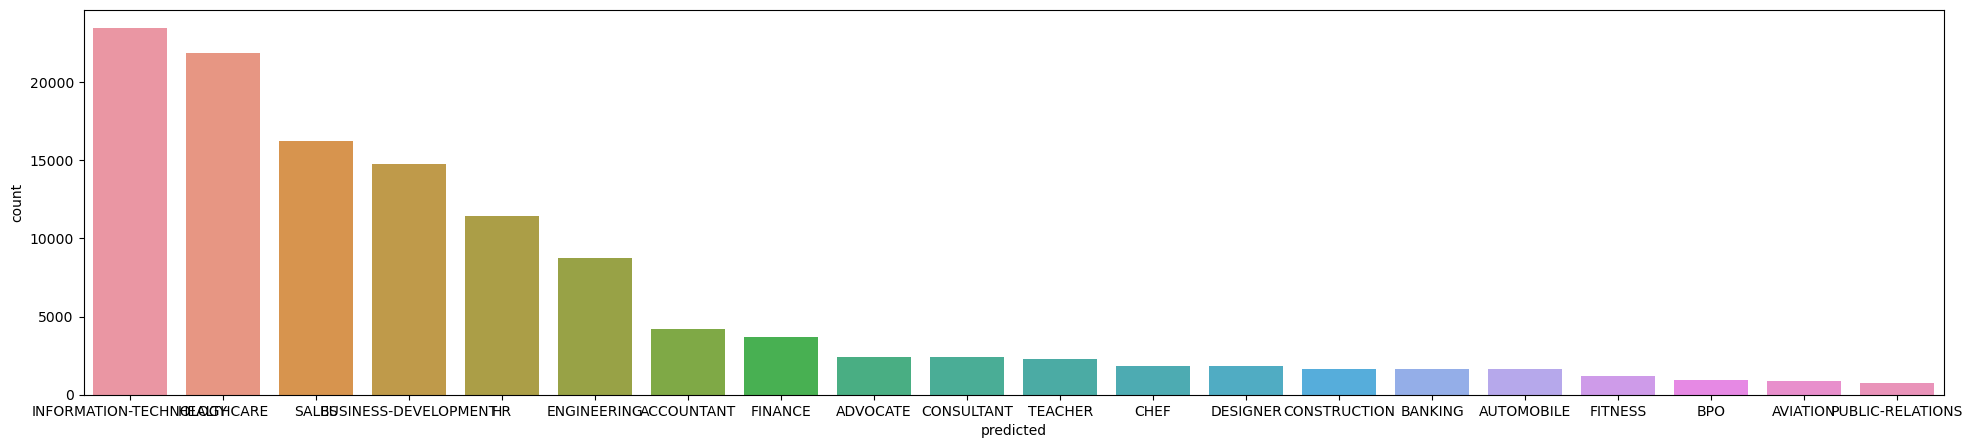

In [94]:
plt.figure(figsize=(24,5))
postings_cat = pd.DataFrame(postings_cat).reset_index().rename(columns={"index": "value", 0: "count"})
sns.barplot(x='predicted', y='count', data=postings_cat)
plt.savefig(FIG_PATH + "postings_categories.png")

## BM25 Ranking

In [17]:
from ranker import BM25, Ranker

scorer = BM25(main_index)
ranker = Ranker(main_index, preprocessor, stopwords, scorer)

In [18]:
bm25_score = run_relevance_tests(postings_category_filename, resume_category_filename, job_category_filename, ranker)
bm25_score

100%|██████████| 124/124 [1:08:56<00:00, 33.36s/it]


{'map': 0.20608934971838197,
 'ndcg': 0.2670740373237783,
 'map_list': [0.0125,
  0.0,
  0.24297619047619046,
  0.0,
  0.0,
  0.3196428571428571,
  0.9,
  0.0,
  0.0,
  0.0,
  0.5497619047619048,
  0.4407142857142857,
  1.0,
  0.0,
  0.0,
  1.0,
  0.6242063492063492,
  0.0,
  0.0,
  0.866388888888889,
  0.016666666666666666,
  0.065,
  0.01,
  0.20666666666666664,
  0.09940476190476191,
  0.1,
  0.045,
  0.13,
  0.0,
  0.0,
  0.0,
  0.38,
  0.01111111111111111,
  0.045,
  0.4730952380952381,
  0.5758730158730159,
  0.1,
  0.0,
  0.0,
  0.025,
  0.0,
  0.3,
  0.14416666666666664,
  0.05,
  0.866388888888889,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.38936507936507936,
  0.0,
  0.0,
  0.016666666666666666,
  0.0,
  0.0,
  0.1,
  0.2652777777777778,
  0.0,
  0.0,
  0.016666666666666666,
  0.0,
  1.0,
  0.01111111111111111,
  0.0,
  0.29464285714285715,
  0.0,
  0.6018253968253967,
  0.22730158730158728,
  0.17777777777777776,
  0.0,
  0.0125,
  0.0,
  0.5063095238095239,
  0.0,
  0.736547619

## Major Class Ranking

In [50]:
# importlib.reload(sys.modules['class_ranker'])
from class_ranker import MajorClassRanker

mc_ranker = MajorClassRanker(postings_category_filename)

In [51]:
mc_score = run_relevance_tests(postings_category_filename, resume_category_filename, job_category_filename, mc_ranker)
mc_score

100%|██████████| 124/124 [00:00<00:00, 129.48it/s]


{'map': 0.04032258064516129,
 'ndcg': 0.04032258064516129,
 'map_list': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'ndcg_list': [0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0,


In [52]:
mc_ranker.major_cat

'INFORMATION-TECHNOLOGY'

## Random Class Ranking

In [53]:
# importlib.reload(sys.modules['class_ranker'])
from class_ranker import RandomClassRanker

rc_ranker = RandomClassRanker(postings_category_filename)

In [54]:
rc_score = run_relevance_tests(postings_category_filename, resume_category_filename, job_category_filename, rc_ranker)
rc_score

100%|██████████| 124/124 [00:00<00:00, 370.38it/s]


{'map': 0.04032258064516129,
 'ndcg': 0.04032258064516129,
 'map_list': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0],
 'ndcg_list': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [81]:
used_cat = Counter(rc_ranker.used_cat)
used_cat

Counter({'AUTOMOBILE': 10,
         'ACCOUNTANT': 10,
         'CONSULTANT': 9,
         'PUBLIC-RELATIONS': 9,
         'BPO': 8,
         'ENGINEERING': 8,
         'TEACHER': 7,
         'FITNESS': 7,
         'HEALTHCARE': 6,
         'BANKING': 6,
         'DESIGNER': 6,
         'AVIATION': 6,
         'HR': 6,
         'SALES': 5,
         'INFORMATION-TECHNOLOGY': 5,
         'BUSINESS-DEVELOPMENT': 5,
         'CHEF': 4,
         'ADVOCATE': 4,
         'CONSTRUCTION': 2,
         'FINANCE': 1})

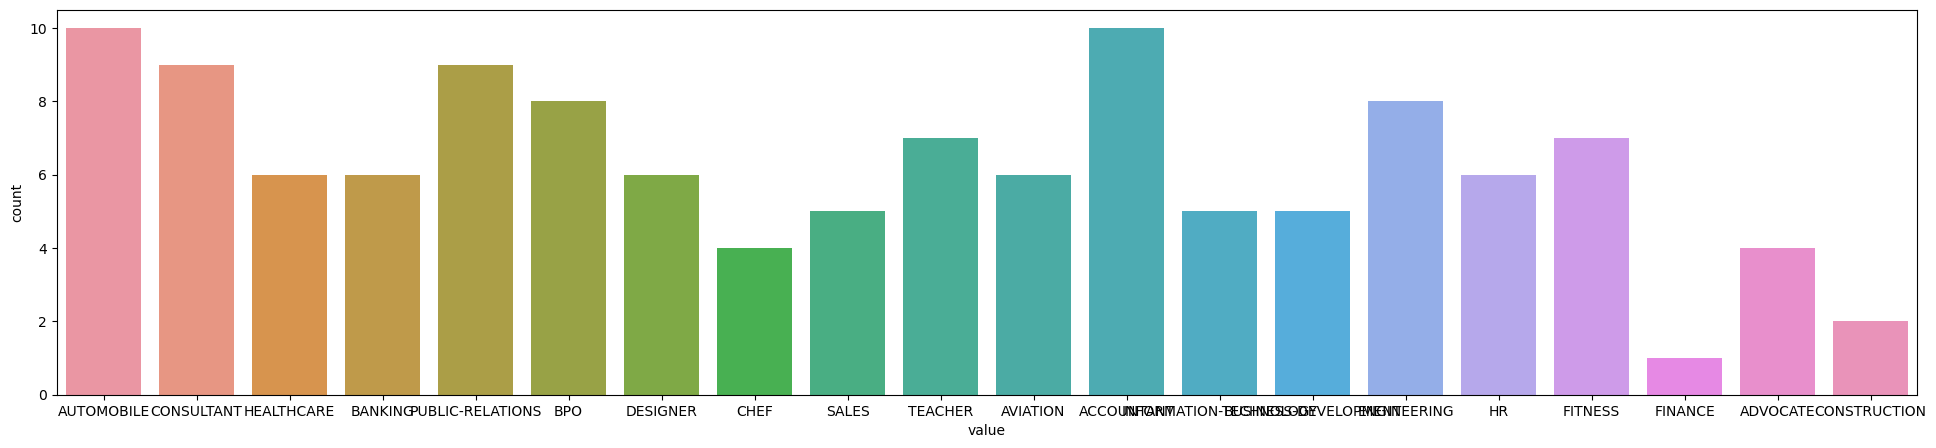

In [82]:
plt.figure(figsize=(24,5))
used_cat = pd.DataFrame.from_dict(used_cat, orient="index").reset_index().rename(columns={"index": "value", 0: "count"})
sns.barplot(x="value", y="count", data=used_cat)
plt.savefig(FIG_PATH + "random_cat.png")

## LLM Ranking

In [85]:
# importlib.reload(sys.modules['class_ranker'])
from class_ranker import LLMRanker

model_name = './posting_classifier/models/job_classification_11091504'
llm_ranker = LLMRanker(model_name, postings_category_filename)

In [86]:
llm_score = run_relevance_tests(postings_category_filename, resume_category_filename, job_category_filename, llm_ranker)
llm_score

100%|██████████| 124/124 [00:13<00:00,  9.04it/s]


{'map': 0.4435483870967742,
 'ndcg': 0.4435483870967742,
 'map_list': [0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0],
 'ndcg_list': [0,
  0,
  1.0,
  1.0,
  0,
  1.0,
  1.0,
  0,
 

## L2R Basic Ranking

In [ ]:
# from l2r import L2RFeatureExtractor, L2RRanker
# from vector_ranker import VectorRanker

# print("creating feature extractor...")
# fe = L2RFeatureExtractor(main_index,
#                             title_index,
#                             # doc_category_info,
#                             preprocessor,
#                             stopwords,
#                             # recognized_categories,
#                             # network_features
#                         )

# print("creating l2r ranker...")
# l2r_basic = L2RRanker(main_index, title_index, preprocessor,
#                     stopwords, ranker, fe)

In [ ]:
# print('training...')
# training_data_filename = 'data/hw2_relevance.train.csv'
# l2r_basic.train(training_data_filename)

## L2R Ranking

In [ ]:
# from ranker import CrossEncoderScorer

# print("creating feature extractor...")
# cemodel = CrossEncoderScorer(document_dict, cemodel_name)
# fe = L2RFeatureExtractor(main_index,
#                             title_index,
#                             # doc_category_info,
#                             preprocessor,
#                             stopwords,
#                             # recognized_categories,
#                             # network_features,
#                             cemodel
#                         )

# print("creating vector ranker...")
# document_vector_file_path = 'data/wiki-200k-vecs.msmarco-MiniLM-L12-cos-v5.npy'
# embeddings = np.load(document_vector_file_path)
# docids = []
# docids_file_path = 'data/document-ids.txt'
# with open(docids_file_path, 'r') as f:
#     for line in tqdm(f):
#         docids.append(int(line))
# model_name = 'sentence-transformers/msmarco-MiniLM-L12-cos-v5'
# ranker = VectorRanker(model_name, embeddings, docids)

# print("creating l2r ranker...")
# l2r_basic = L2RRanker(main_index, title_index, preprocessor,
#                     stopwords, ranker, fe)

## Plot

number of queries 124


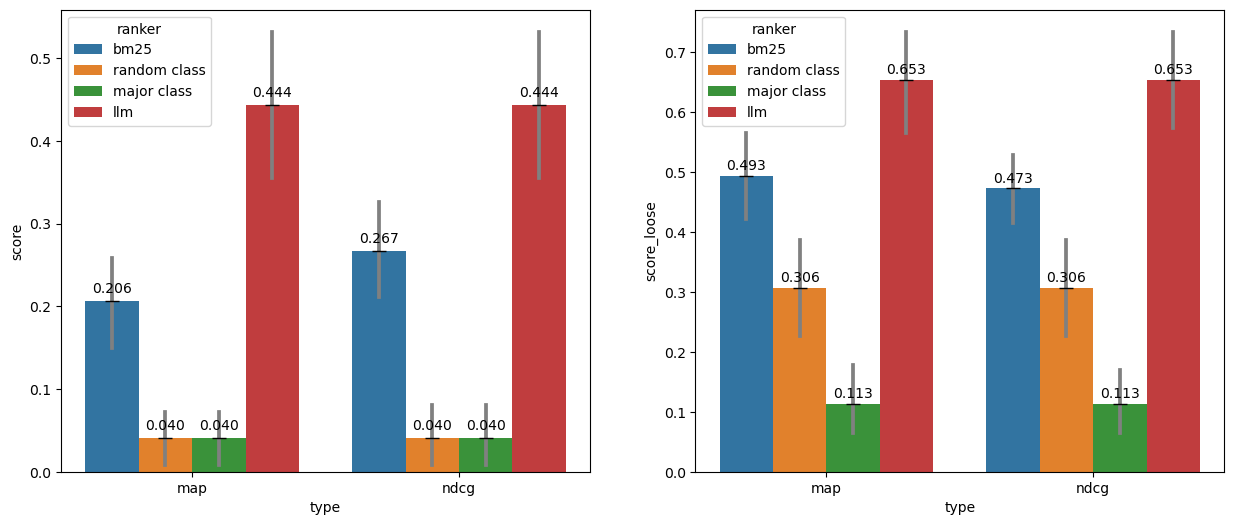

In [87]:
df = []
l = len(bm25_score['map_list'])
print("number of queries", l)
for i in range(l):
    df.append({'ranker': 'bm25', 'type': 'map', 'score': bm25_score['map_list'][i], 'score_loose': bm25_score['map_loose_list'][i]})
    df.append({'ranker': 'bm25', 'type': 'ndcg', 'score': bm25_score['ndcg_list'][i], 'score_loose': bm25_score['ndcg_loose_list'][i]})
    df.append({'ranker': 'random class', 'type': 'map', 'score': rc_score['map_list'][i], 'score_loose': rc_score['map_loose_list'][i]})
    df.append({'ranker': 'random class', 'type': 'ndcg', 'score': rc_score['ndcg_list'][i], 'score_loose': rc_score['ndcg_loose_list'][i]})
    df.append({'ranker': 'major class', 'type': 'map', 'score': mc_score['map_list'][i], 'score_loose': mc_score['map_loose_list'][i]})
    df.append({'ranker': 'major class', 'type': 'ndcg', 'score': mc_score['ndcg_list'][i], 'score_loose': mc_score['ndcg_loose_list'][i]})
    df.append({'ranker': 'llm', 'type': 'map', 'score': llm_score['map_list'][i], 'score_loose': llm_score['map_loose_list'][i]})
    df.append({'ranker': 'llm', 'type': 'ndcg', 'score': llm_score['ndcg_list'][i], 'score_loose': llm_score['ndcg_loose_list'][i]})
    # df1.append({'ranker': 'l2r_basic', 'type': 'map', 'score': l2r_basic_score['map_list'][i]})
    # df1.append({'ranker': 'l2r_basic', 'type': 'ndcg', 'score': l2r_basic_score['ndcg_list'][i]})
    # df1.append({'ranker': 'l2r', 'type': 'map', 'score': l2r_score['map_list'][i]})
    # df1.append({'ranker': 'l2r', 'type': 'ndcg', 'score': l2r_score['ndcg_list'][i]})
    # df1.append({'ranker': 'l2r_aug', 'type': 'map', 'score': l2r_aug_score['map_list'][i]})
    # df1.append({'ranker': 'l2r_aug', 'type': 'ndcg', 'score': l2r_aug_score['ndcg_list'][i]})

df = pd.DataFrame(df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x='type', y='score', hue='ranker', data=df, errcolor='grey', ax=ax1)
bm25_avg = [bm25_score['map'], bm25_score['ndcg']]
rc_avg = [rc_score['map'], rc_score['ndcg']]
mc_avg = [mc_score['map'], mc_score['ndcg']]
llm_avg = [llm_score['map'], llm_score['ndcg']]
# l2r_basic_avg = [l2r_basic_score['map'], l2r_basic_score['ndcg']]
# l2r_avg = [l2r_score['map'], l2r_score['ndcg']]
# l2r_aug_avg = [l2r_aug_score['map'], l2r_aug_score['ndcg']]
for i, (v1,v2,v3, v4) in enumerate(zip(bm25_avg, rc_avg, mc_avg, llm_avg)):
    ax1.text(i-0.3, v1+0.01, "{:.3f}".format(v1), ha='center', color='black')
    ax1.text(i-0.1, v2+0.01, "{:.3f}".format(v2), ha='center', color='black')
    ax1.text(i+0.1, v3+0.01, "{:.3f}".format(v3), ha='center', color='black')
    ax1.text(i+0.3, v4+0.01, "{:.3f}".format(v4), ha='center', color='black')
    ax1.plot(i-0.3, v1, "_", markersize=10, color="black")
    ax1.plot(i-0.1, v2, "_", markersize=10, color="black")
    ax1.plot(i+0.1, v3, "_", markersize=10, color="black")
    ax1.plot(i+0.3, v4, "_", markersize=10, color="black")

sns.barplot(x='type', y='score_loose', hue='ranker', data=df, errcolor='grey', ax=ax2)
bm25_avg_loose = [bm25_score['map_loose'], bm25_score['ndcg_loose']]
rc_avg_loose = [rc_score['map_loose'], rc_score['ndcg_loose']]
mc_avg_loose = [mc_score['map_loose'], mc_score['ndcg_loose']]
llm_avg_loose = [llm_score['map_loose'], llm_score['ndcg_loose']]
# l2r_basic_avg = [l2r_basic_score['map'], l2r_basic_score['ndcg']]
# l2r_avg = [l2r_score['map'], l2r_score['ndcg']]
# l2r_aug_avg = [l2r_aug_score['map'], l2r_aug_score['ndcg']]
for i, (v1,v2,v3, v4) in enumerate(zip(bm25_avg_loose, rc_avg_loose, mc_avg_loose, llm_avg_loose)):
    ax2.text(i-0.3, v1+0.01, "{:.3f}".format(v1), ha='center', color='black')
    ax2.text(i-0.1, v2+0.01, "{:.3f}".format(v2), ha='center', color='black')
    ax2.text(i+0.1, v3+0.01, "{:.3f}".format(v3), ha='center', color='black')
    ax2.text(i+0.3, v4+0.01, "{:.3f}".format(v4), ha='center', color='black')
    ax2.plot(i-0.3, v1, "_", markersize=10, color="black")
    ax2.plot(i-0.1, v2, "_", markersize=10, color="black")
    ax2.plot(i+0.1, v3, "_", markersize=10, color="black")
    ax2.plot(i+0.3, v4, "_", markersize=10, color="black")
plt.savefig(FIG_PATH + 'ranker_scores.png')

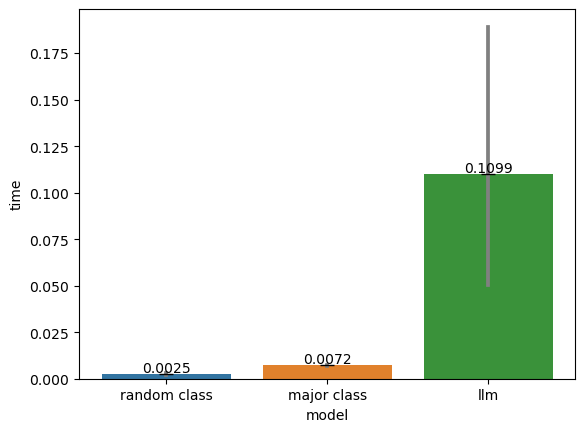

In [89]:
import numpy as np
df = []
for i in range(len(rc_score["time"])):
    # df.append({'model': 'bm25', 'time': bm25_score['time']})
    df.append({'model': 'random class', 'time': rc_score['time'][i]})
    df.append({'model': 'major class', 'time': mc_score['time'][i]})
    df.append({'model': 'llm', 'time': llm_score['time'][i]})
    
df = pd.DataFrame(df)
ax = sns.barplot(x='model', y='time', data=df, errcolor="grey")
time_avg = [np.mean(rc_score['time']), np.mean(mc_score['time']), np.mean(llm_score['time'])]
for i, v in enumerate(time_avg):
    ax.text(i, v+0.001, "{:.4f}".format(v), ha='center', color='black')
    ax.plot(i, v, "_", markersize=10, color="black")
plt.savefig(FIG_PATH + 'ranking_time.png')